# **1. Preliminary preparation**

## *1.1 Execution Environment*
This notebook was executed in a terminal-based Spark CLI session (using pyspark) with the Cassandra connector. SparkSession is initialized automatically.

## *1.2 Data Upload to HDFS*

In [ ]:
wget http://media.sundog-soft.com/hadoop/ml-100k/u.data -O /tmp/u.data
wget http://media.sundog-soft.com/hadoop/ml-100k/u.item -O /tmp/u.item
wget http://media.sundog-soft.com/hadoop/ml-100k/u.user -O /tmp/u.user

In [ ]:
hadoop fs -put /tmp/u.data /user/maria_dev/
hadoop fs -put /tmp/u.item /user/maria_dev/
hadoop fs -put /tmp/u.user /user/maria_dev/

## *1.3 CREATE KEYSPACE (use cqlsh)*

In [ ]:
# entry cqlsh
cqlsh

# create keyspace
CREATE KEYSPACE IF NOT EXISTS movielens
WITH replication = {'class': 'SimpleStrategy', 'replication_factor': 1};

In [ ]:
# Create the user table
CREATE TABLE IF NOT EXISTS movielens.user (
    user_id int PRIMARY KEY,
    age int,
    gender text,
    occupation text,
    zip_code text
);

In [ ]:
# Create the ratings table
CREATE TABLE IF NOT EXISTS movielens.rating (
    user_id int,
    movie_id int,
    rating int,
    timestamp text,
    PRIMARY KEY (user_id, movie_id)
);

In [ ]:
# Create the item table
CREATE TABLE IF NOT EXISTS movielens.item (
    movie_id int PRIMARY KEY,
    movie_title text,
    release_date text,
    video_release_date text,
    imdb_url text,
    unknown int,
    Action int,
    Adventure int,
    Animation int,
    Children int,
    Comedy int,
    Crime int,
    Documentary int,
    Drama int,
    Fantasy int,
    film_noir int,
    Horror int,
    Musical int,
    Mystery int,
    Romance int,
    sci_fi int,
    Thriller int,
    War int,
    Western int
);

## *1.4 Start Spark*

In [ ]:
pyspark --packages com.datastax.spark:spark-cassandra-connector_2.11:2.4.3

# **2. Importing data using pyspark**

## 2.1 Import Required Libraries

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window
from pyspark.sql.functions import explode, array, lit, when
from pyspark.sql.functions import row_number
from pyspark.sql.functions import count

## 2.2 Load u.user

In [ ]:
user_rdd = spark.sparkContext.textFile("hdfs:///user/maria_dev/u.user")
user_row_rdd = user_rdd.map(lambda line: line.split("|")) \
                        .map(lambda x: (int(x[0]), int(x[1]), x[2], x[3], x[4]))

In [ ]:
user_schema = StructType([
    StructField("user_id", IntegerType(), True),
    StructField("age", IntegerType(), True),
    StructField("gender", StringType(), True),
    StructField("occupation", StringType(), True),
    StructField("zip_code", StringType(), True)
])

user_df = spark.createDataFrame(user_row_rdd, schema=user_schema)

## 2.3 Load u.data

In [ ]:
rating_rdd = spark.sparkContext.textFile("hdfs:///user/maria_dev/u.data")
rating_row_rdd = rating_rdd.map(lambda line: line.split("\t")) \
                            .map(lambda x: (int(x[0]), int(x[1]), int(x[2]), x[3]))

In [ ]:
rating_schema = StructType([
    StructField("user_id", IntegerType(), True),
    StructField("movie_id", IntegerType(), True),
    StructField("rating", IntegerType(), True),
    StructField("timestamp", StringType(), True)
])

rating_df = spark.createDataFrame(rating_row_rdd, schema=rating_schema)

## 2.4 Load u.item

In [ ]:
item_rdd = spark.sparkContext.textFile("hdfs:///user/maria_dev/u.item")
item_row_rdd = item_rdd.map(lambda line: line.split("|")) \
                        .map(lambda x: (
    int(x[0]), x[1], x[2], x[3], x[4]
) + tuple(int(g) for g in x[5:24]))

In [ ]:
item_schema = StructType([
    StructField("movie_id", IntegerType(), True),
    StructField("movie_title", StringType(), True),
    StructField("release_date", StringType(), True),
    StructField("video_release_date", StringType(), True),
    StructField("imdb_url", StringType(), True),
    StructField("unknown", IntegerType(), True),
    StructField("action", IntegerType(), True),
    StructField("adventure", IntegerType(), True),
    StructField("animation", IntegerType(), True),
    StructField("children", IntegerType(), True),
    StructField("comedy", IntegerType(), True),
    StructField("crime", IntegerType(), True),
    StructField("documentary", IntegerType(), True),
    StructField("drama", IntegerType(), True),
    StructField("fantasy", IntegerType(), True),
    StructField("film_noir", IntegerType(), True),
    StructField("horror", IntegerType(), True),
    StructField("musical", IntegerType(), True),
    StructField("mystery", IntegerType(), True),
    StructField("romance", IntegerType(), True),
    StructField("sci_fi", IntegerType(), True),
    StructField("thriller", IntegerType(), True),
    StructField("war", IntegerType(), True),
    StructField("western", IntegerType(), True)
])

item_df = spark.createDataFrame(item_row_rdd, schema=item_schema)

# **3. Write DataFrame to Cassandra Keyspace**

In [ ]:
user_df.write \
    .format("org.apache.spark.sql.cassandra") \
    .options(table="user", keyspace="movielens") \
    .mode("append") \
    .save()

In [ ]:
rating_df.write \
    .format("org.apache.spark.sql.cassandra") \
    .options(table="rating", keyspace="movielens") \
    .mode("append") \
    .save()

In [ ]:
item_df.write \
    .format("org.apache.spark.sql.cassandra") \
    .options(table="item", keyspace="movielens") \
    .mode("append") \
    .save()

# **4. Read Back from Cassandra**

In [ ]:
# user
user_df_cassandra = spark.read \
    .format("org.apache.spark.sql.cassandra") \
    .options(table="user", keyspace="movielens") \
    .load()

user_df_cassandra.show(10)

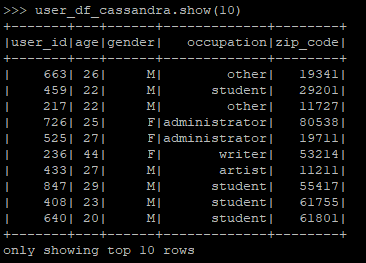

In [15]:
#output
from IPython.display import Image
Image('image/user_df.png', width =400)

In [ ]:
# rating
rating_df_cassandra = spark.read \
    .format("org.apache.spark.sql.cassandra") \
    .options(table="rating", keyspace="movielens") \
    .load()

rating_df_cassandra.show(10)

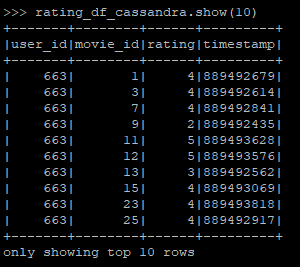

In [16]:
#output
Image('image/rating_df.png', width =400)

In [ ]:
# item
item_df_cassandra = spark.read \
    .format("org.apache.spark.sql.cassandra") \
    .options(table="item", keyspace="movielens") \
    .load()

item_df_cassandra.show(10)

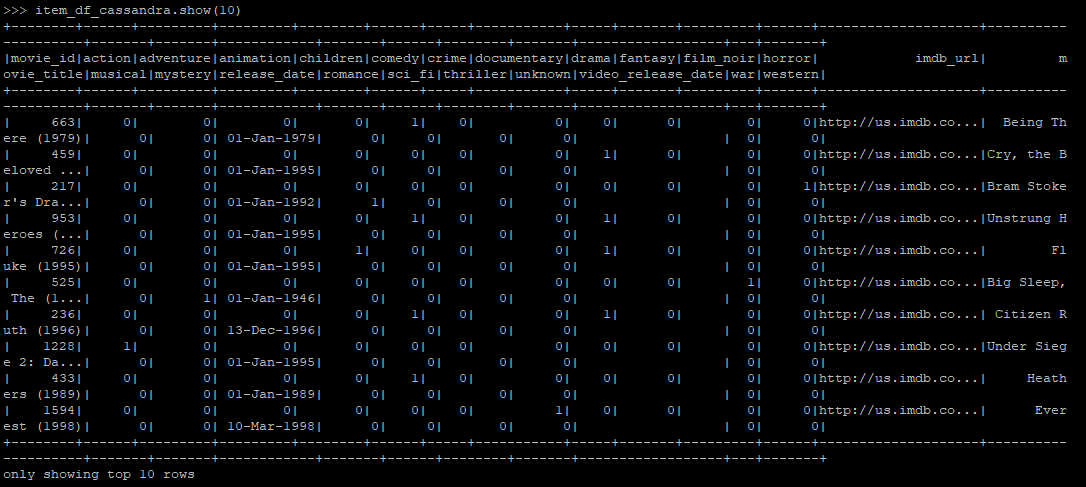

In [22]:
#output
Image('image/item_df.png', width =800)

# **5. Qusetion Part**

## *i - Average rating for each movie*

In [ ]:
avg_rating_df = rating_df_cassandra.groupBy("movie_id").avg("rating") \
    .withColumnRenamed("avg(rating)", "avg_rating")
avg_rating_df.show(10)

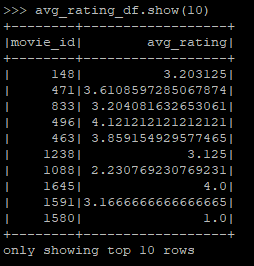

In [23]:
Image('image/Q1.png', width =400)

## *ii - Top 10 movies by average rating*

In [ ]:
top10_df = avg_rating_df.join(item_df_cassandra, on="movie_id") \
    .select("movie_title", "avg_rating") \
    .orderBy(col("avg_rating").desc()) \
    .limit(10)
top10_df.show(truncate=False)

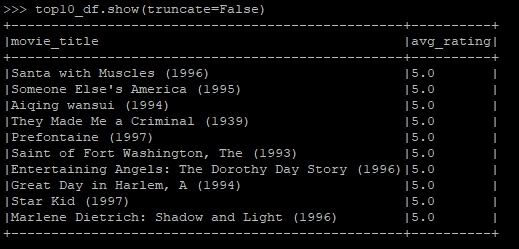

In [27]:
Image('image/Q2.png', width =600)

## *iii - Active users (≥50 ratings) and favourite genres*

In [ ]:
genre_cols = ["unknown", "action", "adventure", "animation", "children", "comedy", "crime",
              "documentary", "drama", "fantasy", "film_noir", "horror", "musical", "mystery",
              "romance", "sci_fi", "thriller", "war", "western"]

genre_array = array(*[
    when(col(g) == 1, lit(g)).otherwise(lit(None)) for g in genre_cols
])

exploded_item = item_df_cassandra.withColumn("genre_array", genre_array) \
    .withColumn("genre", explode("genre_array")) \
    .filter(col("genre").isNotNull()) \
    .select("movie_id", "genre")

In [ ]:
# Find users with ≥50 ratings
active_users = rating_df_cassandra.groupBy("user_id").agg(count("*").alias("rating_count")) \
    .filter("rating_count >= 50")

In [ ]:
# Join rating and genre
active_ratings = rating_df_cassandra.join(active_users, on="user_id")
user_genres = active_ratings.join(exploded_item, on="movie_id")

In [ ]:
# Count most frequent genres per user
user_genre_count = user_genres.groupBy("user_id", "genre") \
    .agg(count("*").alias("genre_rating_count"))

In [ ]:
window_spec = Window.partitionBy("user_id").orderBy(col("genre_rating_count").desc())

top_genre_per_user = user_genre_count.withColumn("rank", row_number().over(window_spec)) \
    .filter("rank = 1") \
    .select("user_id", "genre", "genre_rating_count")

top_genre_per_user.show(10, truncate=False)

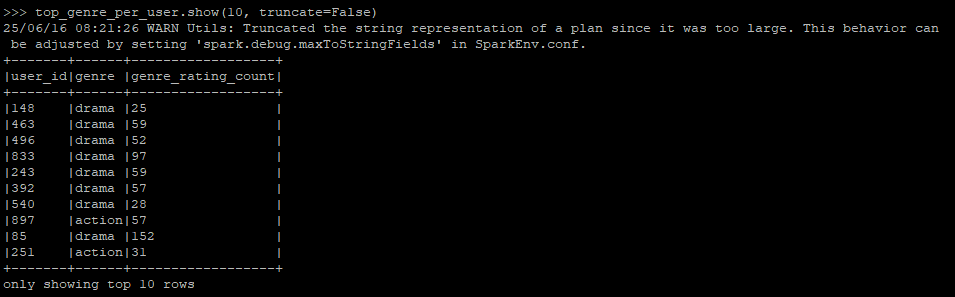

In [31]:
Image('image/Q3.png', width =900)

## *iv - Users younger than 20*

In [ ]:
young_users = user_df.filter("age < 20")
young_users.show(10)

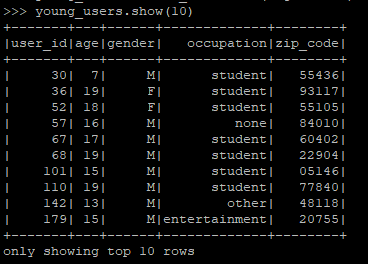

In [32]:
Image('image/Q4.png', width =400)

## *v - Scientists aged 30–40*

In [ ]:
scientists = user_df.filter("occupation = 'scientist' AND age BETWEEN 30 AND 40")
scientists.show(10)

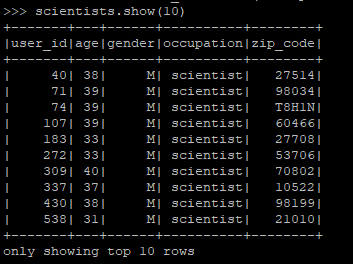

In [33]:
Image('image/Q5.png', width =400)